In [1]:
import pandas as pd

filepath_dict = {'yelp':   'data/yelp_labelled.txt',
                 'amazon': 'data/amazon_cells_labelled.txt',
                 'imdb':   'data/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [2]:
df.head()

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


Collection of text is called corpus in NLP

he vocabulary in this case is a list of words that occurred in our text where each word has its own index. This enables you to create a vector for a sentence. You would then take the sentence you want to vectorize, and you count each occurrence in the vocabulary. The resulting vector will be with the length of the vocabulary and a count for each word in the vocabulary.

The resulting vector is also called a feature vector. In a feature vector, each dimension can be a numeric or categorical feature, like for example the height of a building, the price of a stock, or, in our case, the count of a word in a vocabulary. These feature vectors are a crucial piece in data science and machine learning, as the model you want to train depends on them.

In [3]:
# example (Bag of words model)
sentences = ['John likes ice cream', 'John hates chocolate.']

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(sentences)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [5]:
vectorizer.transform(sentences).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]])

## Define a baseline

This usually involves a simple model, which is then used as a comparison with the more advanced models that you want to test.

In [6]:
from sklearn.model_selection import train_test_split

df_yelp = df[df['source'] == 'yelp']

sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
   sentences, y, test_size=0.25, random_state=1000)

In [7]:
# use bag of words to vectorize with countvectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

You can see that the resulting feature vectors have 750 samples which are the number of training samples we have after the train-test split. Each sample has 2505 dimensions which is the size of the vocabulary. Also, you can see that we get a sparse matrix. This is a data type that is optimized for matrices with only a few non-zero elements, which only keeps track of the non-zero elements reducing the memory load.

CountVectorizer performs tokenization which separates the sentences into a set of tokens as you saw previously in the vocabulary. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the NLTK library with the CountVectorizer or use any number of the customizations which you can explore to improve the performance of your model.

* can also use ngram and other parameters

In [8]:
# Use logistic regression for baseline
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


In [9]:
# lets see how does on other data
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test  = vectorizer.transform(sentences_test)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


### Deep Learning - Binary Classification
You can also use different loss functions, but in this tutorial you will only need the cross entropy loss function or more specifically binary cross entropy which is used for binary classification problems. Be sure to experiment with the various available methods and tools. Some researchers even claim in a recent article that the choice for the best performing methods borders on alchemy. The reason being that many methods are not well explained and consist of a lot of tweaking and testing.
https://www.science.org/content/article/ai-researchers-allege-machine-learning-alchemy

In [10]:
from keras.models import Sequential
from keras import layers

input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2021-11-04 22:49:54.642657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Before you can start with the training of the model, you need to configure the learning process. This is done with the .compile() method. This method specifies the optimizer and the loss function.

In [11]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                25060     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 25,071
Trainable params: 25,071
Non-trainable params: 0
_________________________________________________________________


You might notice that we have 25060 parameters for the first layer and another 11 in the second one. Where did those come from?

See, we have 2505 dimensions for each feature vector, and then we have 10 nodes. We need weights for each feature dimension and each node which accounts for 2505 * 10 = 25050 parameters, and then we have another 10 times an added bias for each node, which gets us the 25060 parameters. In the final node, we have another 10 weights and one bias, which gets us to 11 parameters. That’s a total of 25071 parameters for both layers.

In [12]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)

/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
2021-11-04 22:49:59.881685: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Now you can use the .evaluate() method to measure the accuracy of the model. You can do this both for the training data and testing data.

Note that if you rerun the .fit() method, you’ll start off with the computed weights from the previous training. Make sure to call clear_session() before you start training the model again:

In [13]:
from keras.backend import clear_session
clear_session()

In [14]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7754


You can already see that the model was overfitting since it reached 100% accuracy for the training set. But this was expected since the number of epochs was fairly large for this model. However, the accuracy of the testing set has already surpassed our previous logistic Regression with BOW model, which is a great step further in terms of our progress.

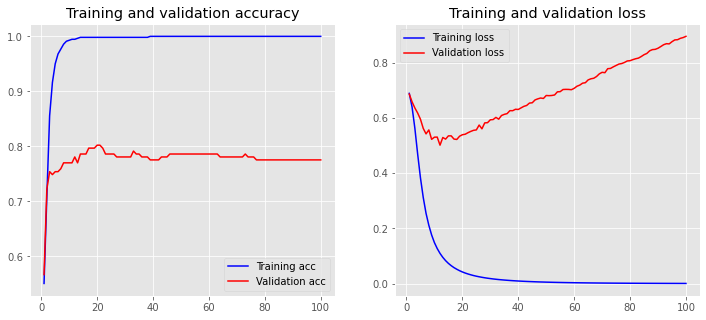

In [16]:
# Visulalize
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

Using the validation set to choose the best model is a form of data leakage (or “cheating”) to get to pick the result that produced the best test score out of hundreds of them. Data leakage happens when information outside the training data set is used in the model.

## Word Embedding

In [17]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

In [18]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)
city_labels

array([1, 0, 0, 2, 1])

Using this representation, you can use the OneHotEncoder provided by scikit-learn to encode the categorical values we got before into a one-hot encoded numeric array.

In [19]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
city_labels = city_labels.reshape((5, 1))
encoder.fit_transform(city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Word Embeddings
This method represents words as dense word vectors (also called word embeddings) which are trained unlike the one-hot encoding which are hardcoded. This means that the word embeddings collect more information into fewer dimensions.

A famous example in this field of study is the ability to map King - Man + Woman = Queen.

How can you get such a word embedding? You have two options for this. One way is to train your word embeddings during the training of your neural network. The other way is by using pretrained word embeddings which you can directly use in your model. There you have the option to either leave these word embeddings unchanged during training or you train them also.

Now you need to tokenize the data into a format that can be used by the word embeddings. Keras offers a couple of convenience methods for text preprocessing and sequence preprocessing which you can employ to prepare your text.

You can start by using the Tokenizer utility class which can vectorize a text corpus into a list of integers. Each integer maps to a value in a dictionary that encodes the entire corpus, with the keys in the dictionary being the vocabulary terms themselves. You can add the parameter num_words, which is responsible for setting the size of the vocabulary. The most common num_words words will be then kep

In [20]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

I am a fan of his ... This movie sucked really bad.  
[7, 150, 2, 932, 4, 49, 6, 11, 563, 45, 30]


In [25]:
for word in ['the', 'all','happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 27


KeyError: 'happy'

In [22]:
from keras.preprocessing.sequence import pad_sequences
# as diff sequences has different lengths, doesn't matter if prepad or post pad

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])
# represents the index in the vocab

[170 116 390  35   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


### Keras Embedding Layer
With the Embedding layer we have now a couple of options. One way would be to take the output of the embedding layer and plug it into a Dense layer. In order to do this you have to add a Flatten layer in between that prepares the sequential input for the Dense layer:



In [26]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           128750    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                50010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 178,771
Trainable params: 178,771
Non-trainable params: 0
_________________________________________________________________


You can now see that we have 87350 new parameters to train. This number comes from vocab_size times the embedding_dim. These weights of the embedding layer are initialized with random weights and are then adjusted through backpropagation during training. This model takes the words as they come in the order of the sentences as input vectors. You can train it with the following:

Training Accuracy: 1.0000
Testing Accuracy:  0.6952


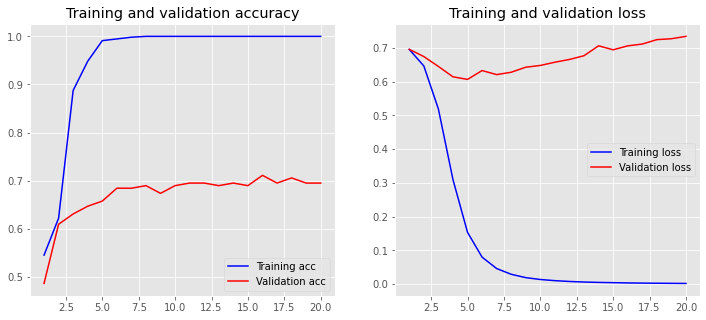

In [27]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

This is typically a not very reliable way to work with sequential data as you can see in the performance. When working with sequential data you want to focus on methods that look at local and sequential information instead of absolute positional information.

Another way to work with embeddings is by using a MaxPooling1D/AveragePooling1D or a GlobalMaxPooling1D/GlobalAveragePooling1D layer after the embedding. You can think of the pooling layers as a way to downsample (a way to reduce the size of) the incoming feature vectors.

In the case of max pooling you take the maximum value of all features in the pool for each feature dimension. In the case of average pooling you take the average, but max pooling seems to be more commonly used as it highlights large values.

Global max/average pooling takes the maximum/average of all features whereas in the other case you have to define the pool size. Keras has again its own layer that you can add in the sequential model:

In [28]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           128750    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 129,271
Trainable params: 129,271
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7754


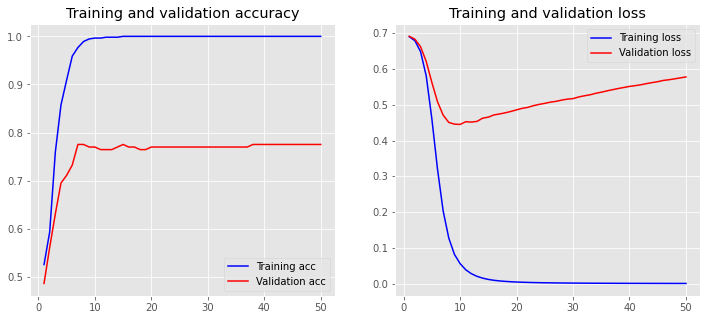

In [29]:
# train the same way
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Using Pretrained Word Embeddings
We just saw an example of jointly learning word embeddings incorporated into the larger model that we want to solve.

An alternative is to use a precomputed embedding space that utilizes a much larger corpus. It is possible to precompute word embeddings by simply training them on a large corpus of text. Among the most popular methods are Word2Vec developed by Google and GloVe (Global Vectors for Word Representation) developed by the Stanford NLP Group.

Note that those are different approaches with the same goal. Word2Vec achieves this by employing neural networks and GloVe achieves this with a co-occurrence matrix and by using matrix factorization. In both cases you are dealing with dimensionality reduction, but Word2Vec is more accurate and GloVe is faster to compute.

In this tutorial, you’ll see how to work with the GloVe word embeddings from the Stanford NLP Group as their size is more manageable than the Word2Vec word embeddings provided by Google. Go ahead and download the 6B (trained on 6 billion words) word embeddings from here (glove.6B.zip, 822 MB).

You can find other word embeddings also on the main GloVe page. You can find the pretrained Word2Vec embeddings by Google here. If you want to train your own word embeddings, you can do so efficiently with the gensim Python package which uses Word2Vec for calculation. More details on how to do this here.

Now that we got you covered, you can start using the word embeddings in your models. You can see in the next example how you can load the embedding matrix. Each line in the file starts with the word and is followed by the embedding vector for the particular word.

This is a large file with 400000 lines, with each line representing a word followed by its vector as a stream of floats. For example, here are the first 50 characters of the first line:

In [30]:
head -n 1 data/glove_word_embeddings/glove.6B.50d.txt | cut -c-50


SyntaxError: invalid syntax (3913143555.py, line 1)


Since you don’t need all words, you can focus on only the words that we have in our vocabulary. Since we have only a limited number of words in our vocabulary, we can skip most of the 40000 words in the pretrained word embeddings:

In [31]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [ ]:
# You can use this function now to retrieve the embedding matrix:

embedding_dim = 50
embedding_matrix = create_embedding_matrix(
    'data/glove_word_embeddings/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

In [ ]:
# First, let’s have a quick look how many of the embedding vectors are nonzero:

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

# 91%of vacab covered by pretrained model

In [ ]:
#  Let’s have a look at the performance when using the GlobalMaxPool1D layer:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Since the word embeddings are not additionally trained, it is expected to be lower. But let’s now see how this performs if we allow the embedding to be trained by using trainable=True:

In [ ]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### CNN

In [32]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          257500    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 322,929
Trainable params: 322,929
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.7861


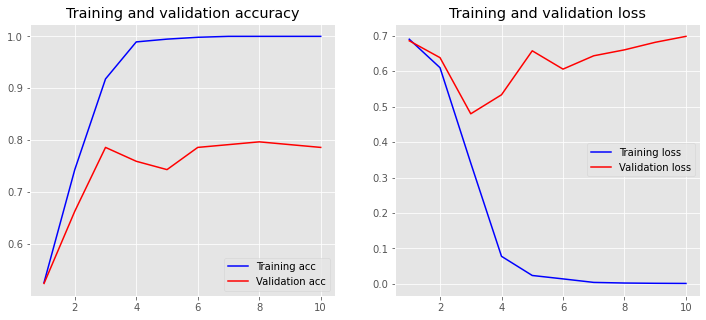

In [33]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

You can see that 80% accuracy seems to be tough hurdle to overcome with this data set and a CNN might not be well equipped. The reason for such a plateau might be that:

There are not enough training samples
The data you have does not generalize well
Missing focus on tweaking the hyperparameters
CNNs work best with large training sets where they are able to find generalizations where a simple model like logistic regression won’t be able.

### Hyperparameters Optimization
One crucial steps of deep learning and working with neural networks is hyperparameter optimization.

As you saw in the models that we have used so far, even with simpler ones, you had a large number of parameters to tweak and choose from. Those parameters are called hyperparameters. This is the most time consuming part of machine learning and sadly there are no one-fits-all solutions ready.

In [34]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [35]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[50],
                  maxlen=[100])

In [36]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Main settings
epochs = 20
embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'

# Run grid search for each source (yelp, amazon, imdb)
for source, frame in df.groupby('source'):
    print('Running grid search for data set :', source)
    sentences = df['sentence'].values
    y = df['label'].values

    # Train-test split
    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # Tokenize words
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(sentences_train)
    X_train = tokenizer.texts_to_sequences(sentences_train)
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # Adding 1 because of reserved 0 index
    vocab_size = len(tokenizer.word_index) + 1

    # Pad sequences with zeros
    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    # Parameter grid for grid search
    param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen])
    model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=4, verbose=1, n_iter=5)
    grid_result = grid.fit(X_train, y_train)

    # Evaluate testing set
    test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    prompt = input(f'finished {source}; write to file and proceed? [y/n]')
    if prompt.lower() not in {'y', 'true', 'yes'}:
        break
    with open(output_file, 'a') as f:
        s = ('Running {} data set\nBest Accuracy : '
             '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
        output_string = s.format(
            source,
            grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
        print(output_string)
        f.write(output_string)

Running grid search for data set : amazon
Fitting 4 folds for each of 5 candidates, totalling 20 fits


KeyboardInterrupt: 

Conclusion
There you have it: you have learned how to work with text classification with Keras, and we have gone from a bag-of-words model with logistic regression to increasingly more advanced methods leading to convolutional neural networks.

You should be now familiar with word embeddings, why they are useful, and also how to use pretrained word embeddings for your training. You have also learned how to work with neural networks and how to use hyperparameter optimization to squeeze more performance out of your model.

One big topic which we have not covered here left for another time was recurrent neural networks, more specifically LSTM and GRU. Those are other powerful and popular tools to work with sequential data like text or time series. Other interesting developments are currently in neural networks that employ attention which are under active research and seem to be a promising next step since LSTM tend to be heavy on the computation.

You have now an understanding of a crucial cornerstone in natural language processing which you can use for text classification of all sorts. Sentiment analysis is the most prominent example for this, but this includes many other applications such as:

Spam detection in emails
Automatic tagging of texts
Categorization of news articles with predefined topics
